In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import scipy.stats as stats
import seaborn as sns
from functions import *

 


%matplotlib inline

# Enoncé

L'agence "Santé publique France" a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. Vous souhaitez y participer et proposer une idée d’application.



# Mission

Votre mission
Après avoir lu l’appel à projets, voici les différentes étapes que vous avez identifiées :

1) Traiter le jeu de données, en :

Réfléchissant à une idée d’application.
Repérant des variables pertinentes pour les traitements à venir, et nécessaires pour votre idée d’application.
Nettoyant les données en :
mettant en évidence les éventuelles valeurs manquantes, avec au moins 3 méthodes de traitement adaptées aux variables concernées,
identifiant et en quantifiant les éventuelles valeurs aberrantes de chaque variable.


2) Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données. Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement.


3) Confirmer ou infirmer les hypothèses à l’aide d’une analyse multivariée. Effectuer les tests statistiques appropriés pour vérifier la significativité des résultats.

4) Justifier votre idée d’application. Identifier des arguments justifiant la faisabilité (ou non) de l’application à partir des données Open Food Facts.

5) Rédiger un rapport d’exploration et pitcher votre idée durant la soutenance du projet.

# Exploration du Dataframe
Dans un premier temps, je vais explorer le DataFrame , sa taille, ses différentes colonnes et géré les différents problèmes de types qu’il pourrait y avoir. 


In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)
openfood=pd.read_csv('fr.openfoodfacts.org.products.csv',sep='\t')
openfood.head()
openfood.shape

C:\Users\pon\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(320772, 162)

Comme une erreur de type est présente sur plusieurs colonnes, je vérifie si celle-ci seront importante à ma problématique ; et comme ce n’est pas le cas, je recharge mon DataFrame avec le paramètre low_memory=’False’ 

In [3]:
openfood.iloc[:, [0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48]].head()

,code,created_t,last_modified_t,manufacturing_places,manufacturing_places_tags,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,allergens,allergens_fr,traces,traces_tags,traces_fr,ingredients_from_palm_oil_tags
0,3087,1474103866,1474103893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,1489069957,1489069957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4559,1489069957,1489069957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16087,1489055731,1489055731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16094,1489055653,1489055653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
openfood=pd.read_csv('fr.openfoodfacts.org.products.csv',sep='\t',low_memory='False')
print(openfood.shape)
openfood.dtypes

C:\Users\pon\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(320772, 162)


code                                           object
url                                            object
creator                                        object
created_t                                      object
created_datetime                               object
last_modified_t                                object
last_modified_datetime                         object
product_name                                   object
generic_name                                   object
quantity                                       object
packaging                                      object
packaging_tags                                 object
brands                                         object
brands_tags                                    object
categories                                     object
categories_tags                                object
categories_fr                                  object
origins                                        object
origins_tags                

# Choix de la problematique

Par cette analyse je vais essayer de voir si les données présentes dans ce Data Frame sont suffisantes pour évaluer le grade nutritionnel d'un produit à l'aide de modèles de prédictions. 

Puis comparer les résultats obtenus et conclure sur la faisabilité du projet et le choix des modèles à privilégié.

J'enlève les lignes dupliqués et comme ‘Code’ est une clé primaire de mon tableau je retire les différents exemplaires de celle-ci 

In [5]:
openfood=openfood[openfood['code'].duplicated()==False]
openfood=openfood[openfood.duplicated()==False]

In [6]:
openfood=openfood[openfood['countries_fr'].str.contains('France')==True]

Je retire toutes les variables numériques ayant une variance nul, cela impliquant que toutes les valeurs sont identiques.
Toutes les colonnes n'yant pas de données
Ainsi que toute les produit n’ayant pas de données pour les colonnes ‘nutrition_grade_fr’ et ‘nutrition-score-fr_100g' qui ne permettront pas d’entrainer les modèles 

In [7]:

openfood=openfood.dropna(1,how='all')
openfood=openfood.dropna(subset=['nutrition_grade_fr'])
openfood=openfood.dropna(subset=['nutrition-score-fr_100g'])
for item in openfood.select_dtypes(include=['float64']).columns.values:
    if openfood[item].std()==0:
        openfood.drop(item,inplace=True)
    



# Séléction d'indicateurs

La sélection des indicateurs se basera sur la pertinence avec la problématiques et le taux de valeurs manquantes. Pour cela je vais visualiser les données manquantes dans mon DataFrame avec missingno, choisir un taux de données manquantes maximum, puis essayer de choisir des variables dont les données manquantes sont corrélées. 

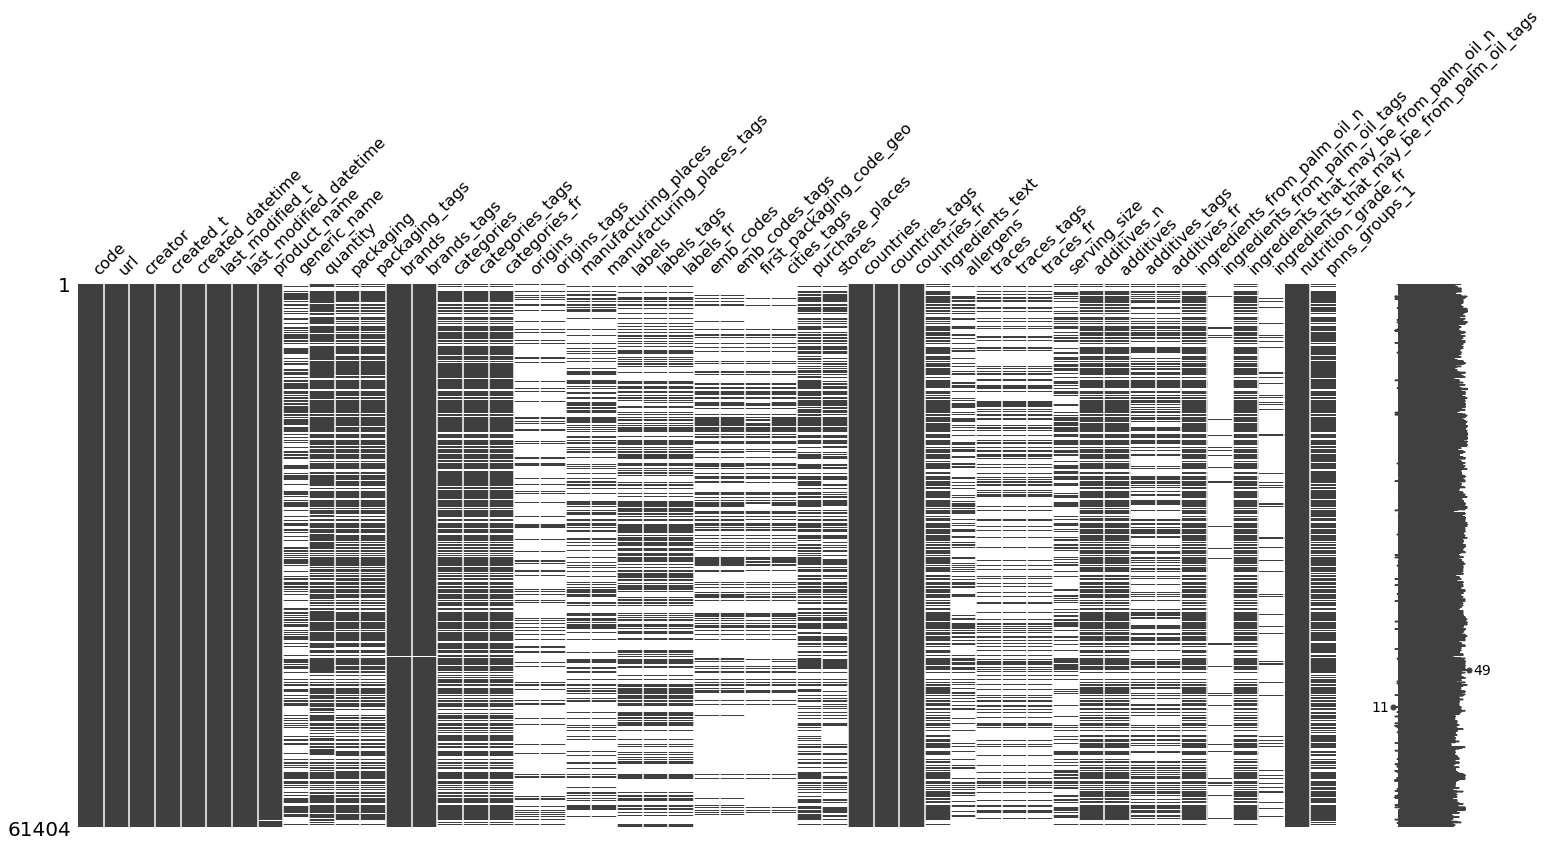

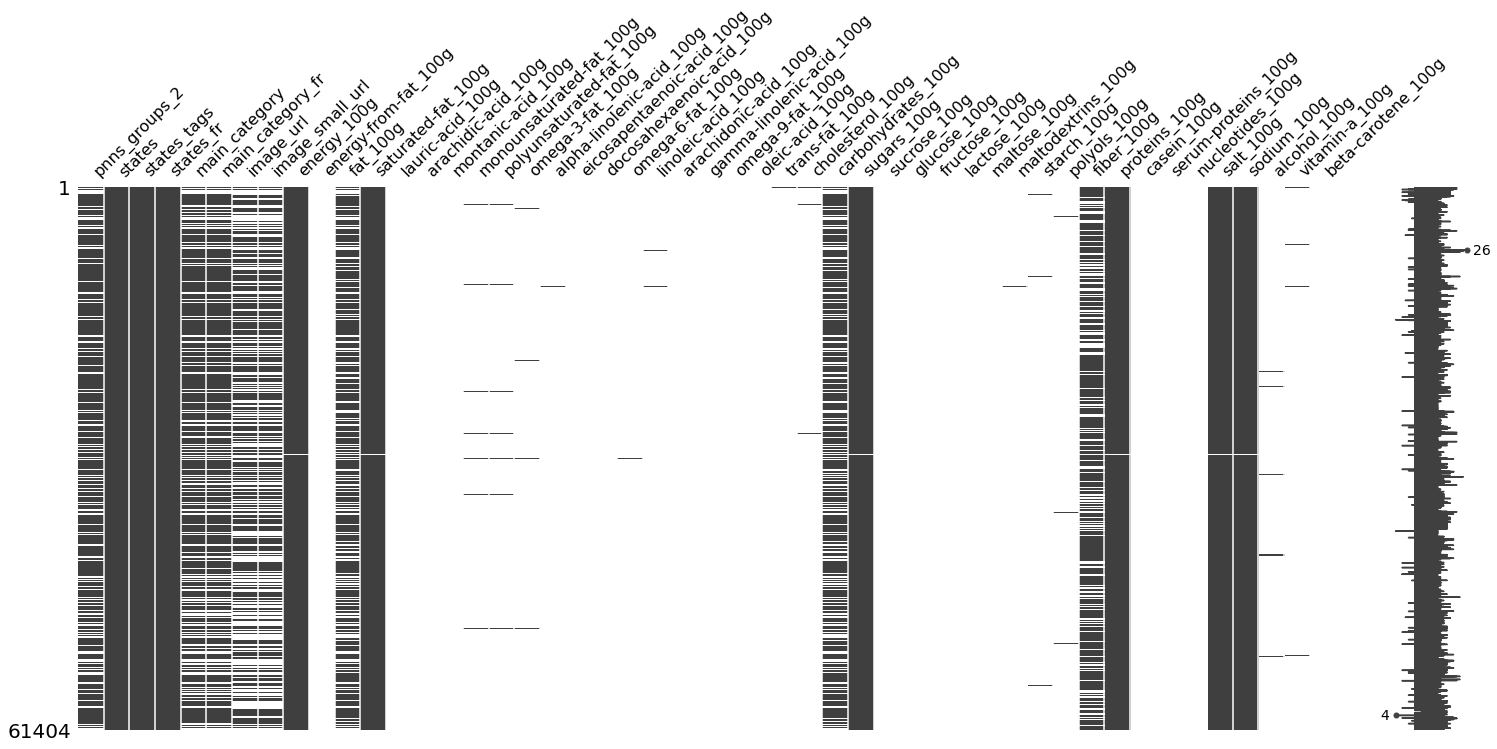

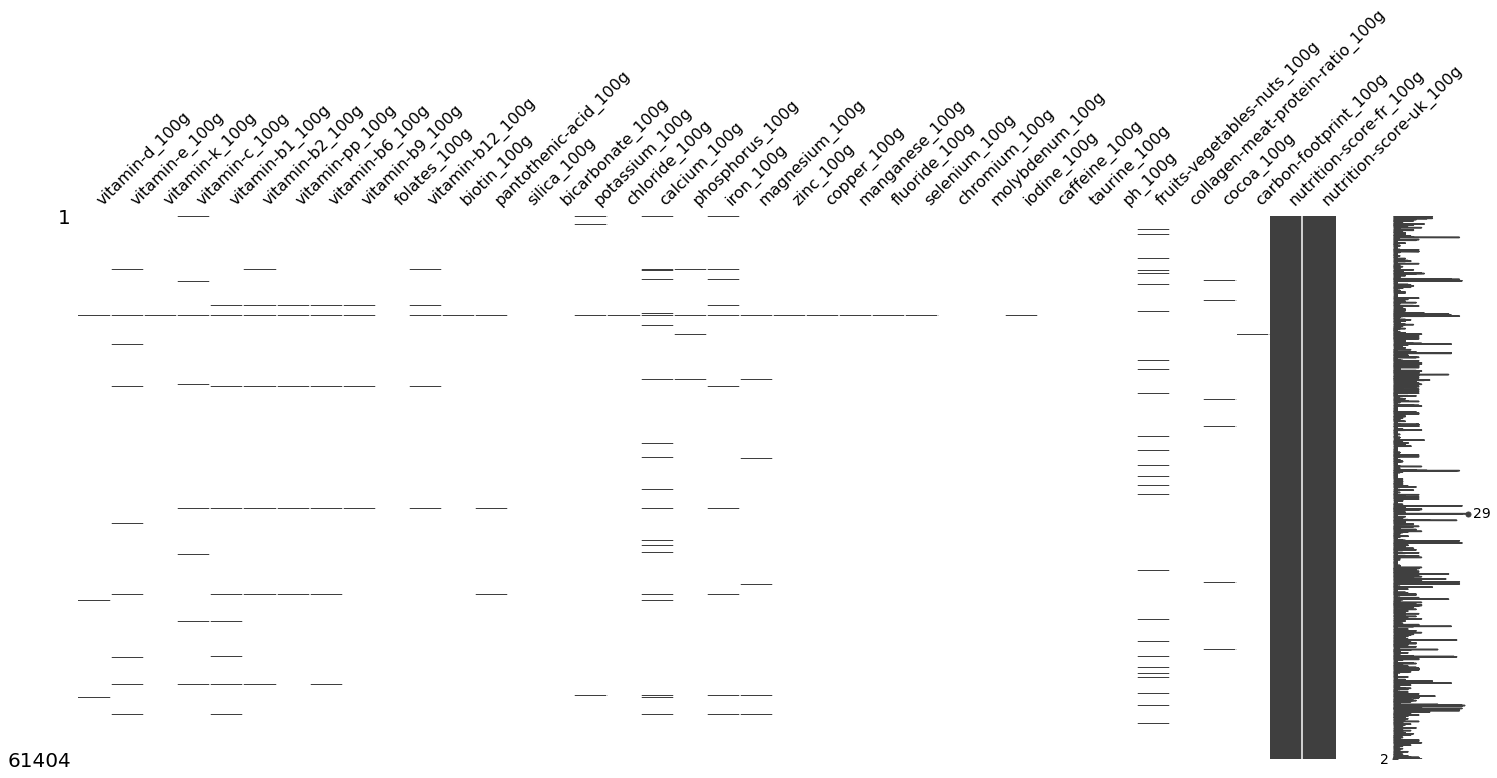

In [8]:
for item in [1,2,3]:
    partiel=openfood.iloc[:,((item-1)*49):(item*49)]
    msno.matrix(partiel)

In [9]:
#Cette ligne séléctionne les collone ayant au maximum 50% de données manquantes
perc = 50.0
min_count =  int(((100-perc)/100)*openfood.shape[0] + 1)
openfood = openfood.dropna( axis=1, thresh=min_count)

<AxesSubplot:>

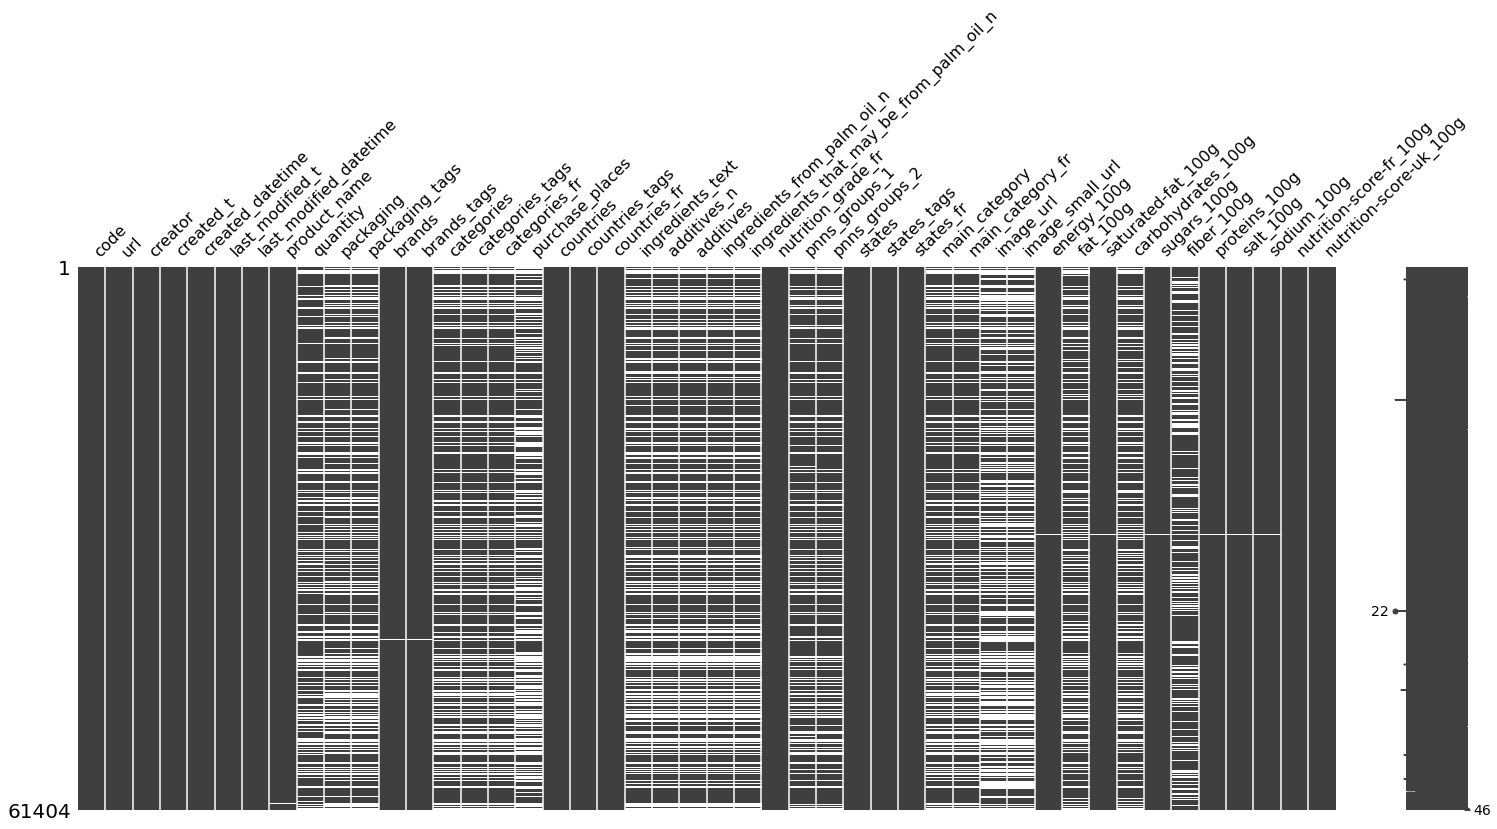

In [10]:
msno.matrix(openfood)


<AxesSubplot:>

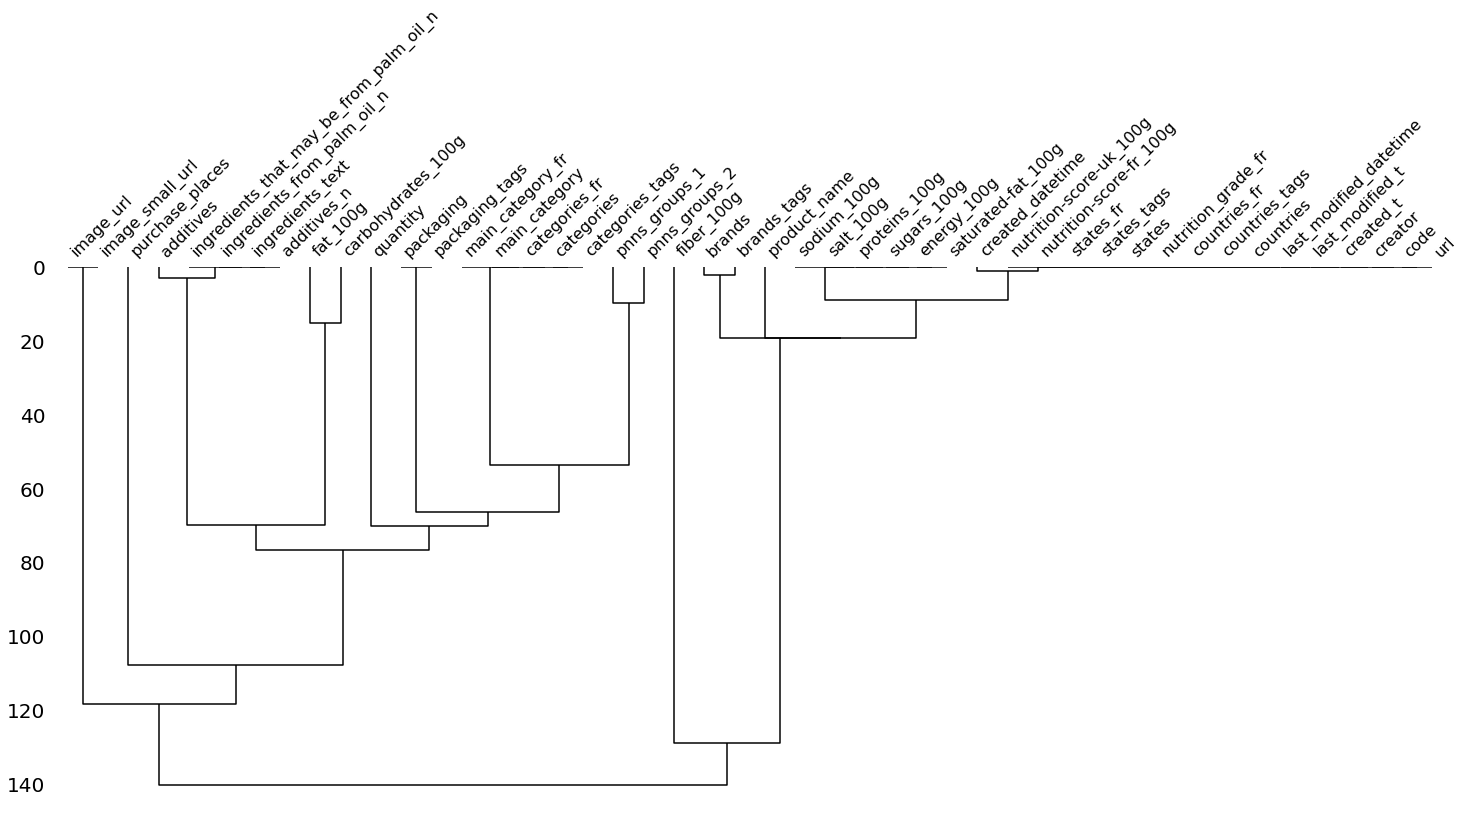

In [11]:
msno.dendrogram(openfood)


En me refferant a https://fr.openfoodfacts.org/nutriscore je selectionne les indicateurs correspondant au calcul du nutriscore

Targets :
 “nutrition_grade_fr“,
 “nutrition-score-fr_100g“

Features :
 'salt_100g',
'energy_100g',
'sugars_100g',
'saturated-fat_100g','carbohydrates_100g',
'fat_100g',
'sodium_100g',
'fiber_100g',
'proteins_100g

In [12]:

open_numeric = openfood.select_dtypes(include=['float64']).columns.values
print(open_numeric)

['additives_n' 'ingredients_from_palm_oil_n'
 'ingredients_that_may_be_from_palm_oil_n' 'energy_100g' 'fat_100g'
 'saturated-fat_100g' 'carbohydrates_100g' 'sugars_100g' 'fiber_100g'
 'proteins_100g' 'salt_100g' 'sodium_100g' 'nutrition-score-fr_100g'
 'nutrition-score-uk_100g']


In [13]:

numeric=['salt_100g','energy_100g','sugars_100g','saturated-fat_100g','carbohydrates_100g','fat_100g','sodium_100g','fiber_100g','proteins_100g']
variables=['nutrition_grade_fr','nutrition-score-fr_100g']+numeric
openfood=openfood[variables]


# Traitement des valeurs abberantes , zscore

 Dans un premier temps je retire toute les valeurs négatives pour mes indicateurs numériques, celle-ci étant évidemment aberrantes 

Ensuite pour repérer autres je vais utiliser l’indicateur de zscore, correspondant au nombre d’écart-type entre une valeurs et la moyenne de la variable, pour chaque colonne 

Zscore(v) = (v-mean(col)) / std(col) 

Et donc si la valeur absolue de celui-ci est supérieure à 3, je remplace la valeur aberrante par un nan. 

In [14]:
for col in numeric:
    openfood[col]=openfood[col].map(lambda v: np.NaN if v < 0 else v,na_action='ignore')
    
    

In [15]:
for col in numeric:
    means=openfood[col].mean()
    stds=openfood[col].std()
    openfood[col]=openfood[col].map(lambda v: np.NaN if abs((v-means)/stds) > 2.5 else v,na_action='ignore')

# Traitement des Nan

Je remplace simplement mes nan par la moyenne de chaque colonne.

In [16]:

for col in openfood[numeric]:
    openfood[col].fillna(openfood[col].mean(),inplace=True)
openfood.groupby('nutrition_grade_fr').describe()

nutrition-score-fr_100g                                   \
                                     count       mean       std   min   25%   
nutrition_grade_fr                                                            
a                                  10218.0  -3.636230  2.320820 -15.0  -5.0   
b                                   9197.0   0.891813  0.948050  -8.0   0.0   
c                                  13183.0   5.677994  2.467173   2.0   4.0   
d                                  16985.0  13.803533  2.546730   6.0  12.0   
e                                  11821.0  21.385670  4.014470  10.0  19.0   

                                     salt_100g            ... fiber_100g  \
                     50%   75%   max     count      mean  ...        75%   
nutrition_grade_fr                                        ...              
a                   -3.0  -2.0  16.0   10218.0  0.336268  ...   3.980000   
b                    1.0   2.0   2.0    9197.0  0.539427  ...   2.132326   
c                    5.0   8.0  10.0   13183.0  0.840777  ...   2.300000   
d                   14.0  16.0  18.0   16985.0  1.168089  ...   2.132326   
e                   21.0  24.0  40.0   11821.0  1.031840  ...   2.132326   

                         proteins_100g                                       \
                     max         count      mean       std  min    25%  50%   
nutrition_grade_fr                                                            
a                   14.0       10218.0  7.452504  5.875603  0.0  2.200  7.0   
b                   14.0        9197.0  5.669965  5.874132  0.0  1.000  3.7   
c                   14.0       13183.0  6.769181  6.633434  0.0  1.235  4.8   
d                   14.0       16985.0  8.330570  7.215262  0.0  2.400  6.9   
e                   14.0       11821.0  7.032899  6.002687  0.0  3.300  6.2   

                                
                     75%   max  
nutrition_grade_fr              
a                   11.7  27.3  
b                    7.7  27.3  
c                    9.6  27.3  
d                   12.0  27.3  
e                    8.3  27.2  

[5 rows x 80 columns]

In [17]:
openfood.to_csv('clean.csv',sep='\t',index=False)